In [72]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [73]:
DATA_DIR = os.path.join(os.getcwd(), "data")
FACTORS = [
    "valuation",
    "profitability",
    "growth",
    "quality",
    "liquidity",
    "momentum_and_reversal",
]
TRAIN_PERIOD = pd.date_range("2011-01-05", "2011-12-31", freq="7D")
TEST_PERIOD = pd.date_range("2016-01-01", "2016-12-31", freq="7D")
BASELINE_DATE = pd.to_datetime("2002-05-21")

In [74]:
class Stock:
    def __init__(self, name, df_price: pd.DataFrame, df_stats: pd.DataFrame):
        self.name = name
        self.df = df_price
        self.dfStat = df_stats

    def __str__(self):
        return self.name

    def calcFactor(self, factor, currentTime):
        dfTime = self.df[self.df["Date"] <= pd.to_datetime(currentTime)].tail(1)
        dfStatTime = self.dfStat[self.dfStat.Date <= pd.to_datetime(currentTime)].tail(
            1
        )
        if factor == "size":
            return dfStatTime["SIZE"]
        elif factor == "valuation":
            return dfStatTime["PBR"].mean()
        elif factor == "profitability":
            return dfStatTime["ROE"].mean()
        elif factor == "growth":
            return dfStatTime["GROWTH"].mean()
        elif factor == "quality":
            return dfStatTime["Current Ratio"].mean()
        elif factor == "liquidity":
            return dfTime["ILLIQ"].mean()
        elif factor == "momentum_and_reversal":
            return (
                self.df[self.df["Date"] <= pd.to_datetime(currentTime)]
                .tail(1)
                .iloc[0]["Close"]
                - self.df[
                    self.df["Date"]
                    <= pd.to_datetime(currentTime) - pd.Timedelta(60, unit="d")
                ]
                .tail(1)
                .iloc[0]["Close"]
            )
        else:
            return None

    def calcReturn(self, currentTime, timeFrame):
        return (
            self.df[self.df["Date"] <= pd.to_datetime(currentTime)]
            .tail(timeFrame)
            .iloc[0]["Close"]
            - self.df[
                self.df["Date"]
                <= pd.to_datetime(currentTime) - pd.Timedelta(timeFrame, unit="d")
            ]
            .tail(1)
            .iloc[0]["Close"]
        )

In [75]:
class StockPile:
    def __init__(self, name="StockPile"):
        self.name = name
        self.stocks = []

    def __str__(self):
        return self.name

    def addStock(self, stock: Stock):
        self.stocks.append(stock)

    def calcIC(self, factor, currentTime, timeFrame=1):
        factor = [stock.calcFactor(factor, currentTime) for stock in self.stocks]
        alpha = [stock.calcReturn(currentTime, timeFrame) for stock in self.stocks]
        return np.corrcoef(factor, alpha)[0][1]

    def calcICBulk(self, currentTime):
        return [self.calcIC(factor, currentTime, 1) for factor in FACTORS]+[self.calcIC(factor, currentTime, 5) for factor in FACTORS]+[self.calcIC(factor, currentTime, 10) for factor in FACTORS]


In [76]:
stocks = ["AAPL", "AXP", "AMGN", "BA", "CAT", "CVX", "CSCO", "GS"]
dow30 = StockPile("DOW30")
for stock in stocks:
    df_price = pd.read_csv(os.path.join(DATA_DIR, f"{stock}.csv"), parse_dates=["Date"])
    df_stats = pd.read_csv(
        os.path.join(DATA_DIR, f"{stock}_STAT.csv"), parse_dates=["Date"]
    )
    dow30.addStock(Stock(stock, df_price, df_stats))


In [77]:
dow30.calcIC("valuation", "2020-01-01", 10)

-0.27162876025549015

In [78]:
from xgboost import XGBRegressor

xgbModel = XGBRegressor(
    n_estimators=100,
    learning_rate=0.02,
    max_depth=4,
    min_child_weight=3,
    gamma=20,
    subsample=0.8,
    colsample_bytree=1,
    reg_lambda=10,
)    
valuationModel = xgbModel
profitabilityModel = xgbModel
growthModel = xgbModel
qualityModel = xgbModel
liquidityModel = xgbModel
mrModel = xgbModel

In [79]:
ic = []
nextic = []
date = []

for i in trange(len(TRAIN_PERIOD)):
    date.append(TRAIN_PERIOD[i])
    ic.append(dow30.calcICBulk(TRAIN_PERIOD[i]))
    if i < len(TRAIN_PERIOD) - 1:
        nextic.append([dow30.calcIC(factor, TRAIN_PERIOD[i + 1]) for factor in FACTORS])
    else:
        nextic.append(
            [
                dow30.calcIC(factor, TRAIN_PERIOD[i] + pd.Timedelta(days=7))
                for factor in FACTORS
            ]
        )


100%|██████████| 52/52 [00:08<00:00,  6.13it/s]


In [80]:
Date = pd.DataFrame(date, columns=["Date"])
IC = pd.DataFrame(ic, columns=[factor + "1" for factor in FACTORS] + [factor + "5" for factor in FACTORS] + [factor + "10" for factor in FACTORS])
nextIC = pd.DataFrame(nextic, columns = FACTORS)

icwithdate = pd.concat([Date, IC.iloc[:, 0:6]], axis=1)
icwithdate.set_index("Date", inplace=True)
icwithdate = icwithdate.sub(icwithdate.min(axis=1), axis=0).div(icwithdate.max(axis= 1) -icwithdate.min(axis = 1), axis=0)
icwithdate = icwithdate.div(icwithdate.sum(axis=1), axis=0)
icwithdate

,valuation1,profitability1,growth1,quality1,liquidity1,momentum_and_reversal1
Date,,,,,,
2011-01-05,0.208864,0.200215,0.046448,0.000000,0.333728,0.210744
2011-01-12,0.186573,0.228358,0.000000,0.094761,0.330386,0.159923
2011-01-19,0.172588,0.150389,0.270680,0.208985,0.000000,0.197357
2011-01-26,0.017232,0.000000,0.238212,0.188730,0.247343,0.308484
2011-02-02,0.238744,0.225554,0.197981,0.000000,0.056454,0.281267
2011-02-09,0.205811,0.178819,0.254623,0.207008,0.000000,0.153739
2011-02-16,0.203352,0.207171,0.109312,0.000000,0.230193,0.249971
2011-02-23,0.000000,0.099631,0.177956,0.100687,0.072441,0.549285
2011-03-02,0.001669,0.000000,0.174699,0.005158,0.439444,0.379030


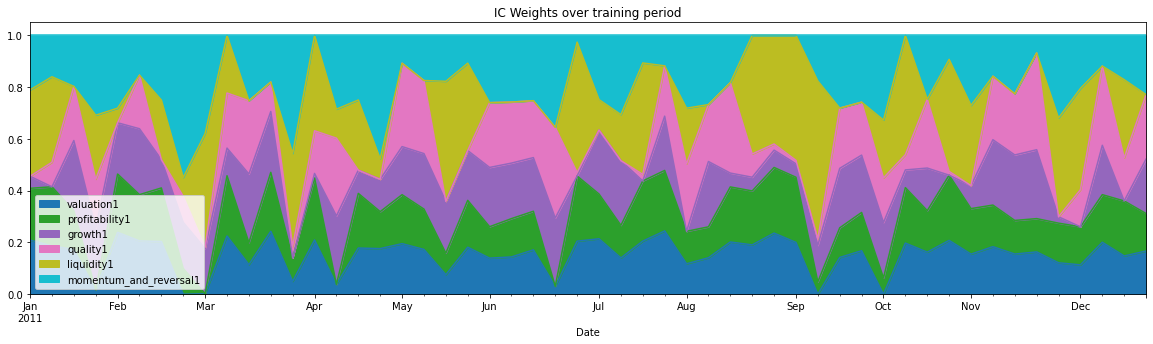

In [81]:
icwithdate.plot.area(figsize=(20, 5), legend=True, colormap="tab10",title="IC Weights over training period")
plt.show()

In [82]:
xgbModel.fit(IC, nextIC)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=20, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.02, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=3,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=10, ...)

In [83]:
xgbModel.predict(np.array(dow30.calcICBulk("2020-01-06")).reshape(1, -1))


array([[0.12032252, 0.11620364, 0.14565468, 0.11870989, 0.08605399,
        0.24154407]], dtype=float32)

In [84]:
xgbModel.predict(pd.DataFrame([[1] * 18] + [[1] * 18]))

array([[0.12032252, 0.11620364, 0.14565468, 0.11870989, 0.08605399,
        0.24154407],
       [0.12032252, 0.11620364, 0.14565468, 0.11870989, 0.08605399,
        0.24154407]], dtype=float32)